In [81]:
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import os



## create all dataframes of selected features

In [27]:
# cdnod_feature_select.ipynb results: related features
features = {'amzn':["M1SL","M2SL","INCOME_STATEMENT_operatingIncome","CASH_FLOW_cashflowFromInvestment","CASH_FLOW_capitalExpenditures","CASH_FLOW_operatingCashflow","CASH_FLOW_changeInOperatingLiabilities","BALANCE_SHEET_cashAndCashEquivalentsAtCarryingValue"],
            'amgn':['CASH_FLOW_changeInOperatingAssets','BALANCE_SHEET_otherCurrentAssets', 'UNRATE','CASH_FLOW_operatingCashflow', 'BALANCE_SHEET_currentDebt'],
            'goog':['INCOME_STATEMENT_incomeTaxExpense','INCOME_STATEMENT_otherNonOperatingIncome','M2SL','CPIAUCSL','CASH_FLOW_paymentsForRepurchaseOfCommonStock','UNRATE','PPIACO','M1SL','CASH_FLOW_cashflowFromFinancing'],
            'abt':['INCOME_STATEMENT_interestAndDebtExpense','CASH_FLOW_proceedsFromRepaymentsOfShortTermDebt','CASH_FLOW_changeInOperatingAssets','CASH_FLOW_depreciationDepletionAndAmortization','CASH_FLOW_changeInReceivables','BALANCE_SHEET_currentDebt'],
            'cvs':['BALANCE_SHEET_totalNonCurrentLiabilities','BALANCE_SHEET_inventory','BALANCE_SHEET_currentDebt','UNRATE','INCOME_STATEMENT_investmentIncomeNet','CASH_FLOW_paymentsForOperatingActivities','BALANCE_SHEET_otherCurrentLiabilities','BALANCE_SHEET_shortTermInvestments', 'CASH_FLOW_depreciationDepletionAndAmortization','INCOME_STATEMENT_nonInterestIncome','INCOME_STATEMENT_interestAndDebtExpense','CASH_FLOW_capitalExpenditures','CASH_FLOW_proceedsFromRepaymentsOfShortTermDebt','BALANCE_SHEET_cashAndCashEquivalentsAtCarryingValue','CASH_FLOW_cashflowFromFinancing','BALANCE_SHEET_propertyPlantEquipment','CASH_FLOW_changeInOperatingAssets','BALANCE_SHEET_otherNonCurrentAssets','CASH_FLOW_changeInOperatingLiabilities','CASH_FLOW_changeInInventory','CASH_FLOW_proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet','BALANCE_SHEET_intangibleAssetsExcludingGoodwill','CASH_FLOW_paymentsForRepurchaseOfCommonStock', 'INCOME_STATEMENT_totalRevenue','CASH_FLOW_cashflowFromInvestment'],
            't':['BALANCE_SHEET_treasuryStock','BALANCE_SHEET_propertyPlantEquipment', 'BALANCE_SHEET_capitalLeaseObligations','BALANCE_SHEET_inventory','CASH_FLOW_paymentsForRepurchaseOfCommonStock','INCOME_STATEMENT_operatingIncome', 'INCOME_STATEMENT_totalRevenue']
}
# data prep for all stocks
def create_df(features, ticker):
    """"take in a list of features and creates a dataframe with those features for a specific company"""
    data_path = f'../data/macro_micro/{ticker}_quarterly.csv'
    macro_features = ['M2SL', 'M1SL', 'FEDFUNDS', 'PPIACO', 'RTWEXBGS', 'CPIAUCSL', 'UNRATE']
    all_selected_features = macro_features + features + ['Quarterly_Return'] + ['fiscalDateEnding']
    df = pd.read_csv(data_path)
    return df[all_selected_features]
# create dfs of selected features (from cdnod)
for ticker in features.keys():
    save_path = f'../data/macro_micro/{ticker}_quarterly_cdnod.csv'
    output = create_df(features[ticker], ticker)
    output.to_csv(save_path, index=False)

## run stepwise selection with svr to determine best model

In [127]:
from xgboost import XGBRegressor

def stepwise_selection_with_xgboost(df):
    # Split into train (80%) and test (20%)
    
    X = df.drop(columns=["Quarterly_Return", "fiscalDateEnding"])
    y = df["Quarterly_Return"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define a base XGBoost model
    xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

    xgb_model.fit(X_train, y_train)
    important_features = X_train.columns[xgb_model.feature_importances_ > 0]  # Keep only useful features

    # Use only the most important features
    X_train_selected = X_train[important_features]
    X_test_selected = X_test[important_features]


    # Define hyperparameter grid for tuning
    param_grid = {
        "n_estimators": [500, 1000, 1500],
        "learning_rate": [0.001, 0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7, 10, 15],
        "subsample": [0.6, 0.8, 1.0], 
        "colsample_bytree": [0.6, 0.8, 1.0], 
        "gamma": [0, 0.1, 0.5, 1], 
        "reg_lambda": [0, 5, 10, 50]
    }



    # Grid Search with Cross-Validation (on training data)
    grid_search = GridSearchCV(XGBRegressor(objective="reg:squarederror", random_state=42), 
                               param_grid, cv=5, scoring="r2", n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)

    # Train the best model on full training set
    best_xgb = grid_search.best_estimator_
    best_xgb.fit(X_train_selected, y_train)
    test_r2 = best_xgb.score(X_test_selected, y_test)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Train R²:", grid_search.best_score_)

    # Output results
    return {
        "Selected Features": list(important_features),
        "Best Parameters": grid_search.best_params_,
        "Train R² (Best CV Score)": grid_search.best_score_,
        "Test R²": test_r2,
        "Best Model": best_xgb,
    }

In [128]:
ticker = 'amgn'

In [129]:
cdnod_quarterly_path = f'../data/macro_micro/{ticker}_quarterly_cdnod.csv'
cdnod_df = pd.read_csv(cdnod_quarterly_path)
best = stepwise_selection_with_xgboost(cdnod_df)

Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 0, 'subsample': 0.6}
Best Train R²: -0.10083093857540186


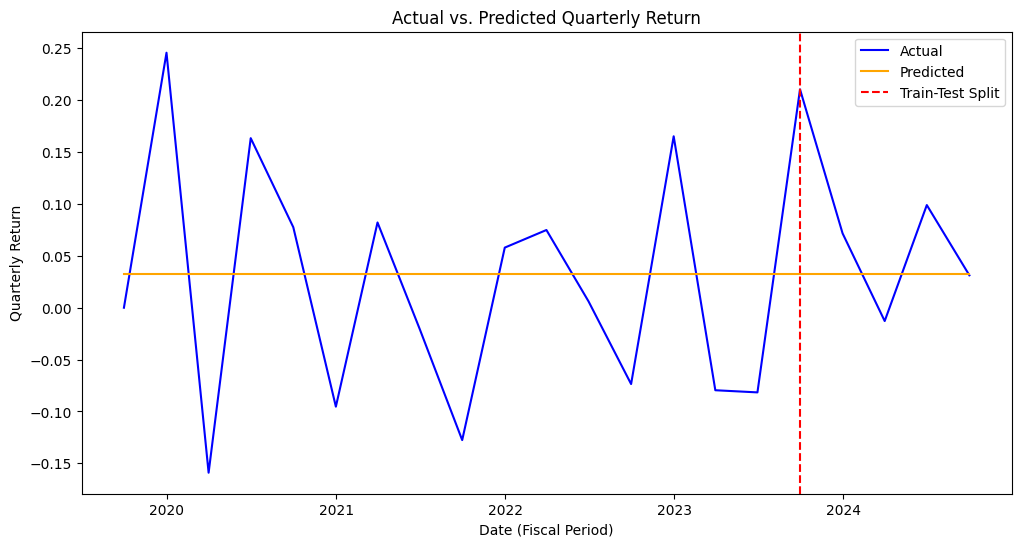

In [ ]:
# plot results
import matplotlib.pyplot as plt
df = cdnod_df
X = df.drop(columns=["Quarterly_Return", "fiscalDateEnding"])
y = df["Quarterly_Return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

selected_features = best["Selected Features"]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
# Get predictions on train and test data
train_predictions = best["Best Model"].predict(X_train_selected)
test_predictions = best["Best Model"].predict(X_test_selected)

# Combine actual and predicted values for plotting
df_plot = df.copy()
df_plot["Predicted"] = list(train_predictions) + list(test_predictions)
df_plot["Dataset"] = ["Train"] * len(y_train) + ["Test"] * len(y_test)

# Sort by date for correct visualization
df_plot["fiscalDateEnding"] = pd.to_datetime(df_plot["fiscalDateEnding"])
df_plot = df_plot.sort_values("fiscalDateEnding")

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(df_plot["fiscalDateEnding"], df_plot["Quarterly_Return"], label="Actual", color="blue")
plt.plot(df_plot["fiscalDateEnding"], df_plot["Predicted"], label="Predicted", color="orange")

# Mark train-test split
split_index = len(y_train)
plt.axvline(df_plot["fiscalDateEnding"].iloc[split_index], color="red", linestyle="--", label="Train-Test Split")

# Labels & legend
plt.xlabel("Date")
plt.ylabel("Quarterly Return")
plt.title("Actual vs. Predicted Quarterly Return")
plt.legend()
plt.show()


In [82]:
def get_extreme_by_quarter(stock_data):
    """
    Assigns quarterly labels based on the date, drops NaN rows, 
    and finds the most extreme stock price movement (largest gain or largest drop) within each quarter.
    Keeps only the row with the most extreme value, renames the column to 'Extreme Value',
    and adds a 'Quarter End Date' column with the last date of the respective quarter.

    Parameters:
    - stock_data (pd.DataFrame): DataFrame containing 'Date', 'Close', and 'Daily Return' columns.

    Returns:
    - pd.DataFrame: Filtered stock data containing only the most extreme movement per quarter.
    """
    stock_data["Quarter"] = None  # Initialize the Quarter column

    # Iterate over each row to assign quarter labels
    for i, row in stock_data.iterrows():
        date = row["Date"]
        year = date.year

        if pd.Timestamp(f"{year}-01-27") <= date <= pd.Timestamp(f"{year}-02-09"):
            stock_data.at[i, "Quarter"] = f"{year-1}-Q4"  # Q4 belongs to the previous year
        elif pd.Timestamp(f"{year}-04-27") <= date <= pd.Timestamp(f"{year}-05-09"):
            stock_data.at[i, "Quarter"] = f"{year}-Q1"
        elif pd.Timestamp(f"{year}-07-27") <= date <= pd.Timestamp(f"{year}-08-09"):
            stock_data.at[i, "Quarter"] = f"{year}-Q2"
        elif pd.Timestamp(f"{year}-10-27") <= date <= pd.Timestamp(f"{year}-11-09"):
            stock_data.at[i, "Quarter"] = f"{year}-Q3"

    # Drop rows where 'Quarter' is NaN
    stock_data = stock_data.dropna(subset=["Quarter"]).copy()

    # Find the most extreme price movement (either largest gain or largest drop) for each quarter
    def find_extreme_row(group):
        max_return_idx = group["Daily Return"].idxmax()  # Index of the max daily return
        min_return_idx = group["Daily Return"].idxmin()  # Index of the min daily return

        max_return = group.loc[max_return_idx, "Daily Return"]
        min_return = group.loc[min_return_idx, "Daily Return"]

        # Determine which is more extreme and keep only that row
        if abs(min_return) > abs(max_return):
            extreme_idx = min_return_idx  # Keep only the row with the most extreme drop
        else:
            extreme_idx = max_return_idx  # Keep only the row with the most extreme gain

        return group.loc[[extreme_idx]]

    # Apply function to each group and reset index
    extreme_stock_data = stock_data.groupby("Quarter", group_keys=False).apply(find_extreme_row).reset_index(drop=True)

    # Rename "Daily Return" to "Extreme Value"
    extreme_stock_data = extreme_stock_data.rename(columns={"Daily Return": "Extreme Value"})

    # Create "Quarter End Date" column based on the quarter label
    def get_quarter_end_date(quarter):
        year, qtr = quarter.split("-")
        quarter_end_dates = {"Q1": "03-31", "Q2": "06-30", "Q3": "09-30", "Q4": "12-31"}
        return f"{year}-{quarter_end_dates[qtr]}"

    extreme_stock_data["Date"] = extreme_stock_data["Quarter"].apply(get_quarter_end_date)

    return extreme_stock_data

stock = pd.read_csv(os.path.join('/Users/vivianzhao/Desktop/CAPSTONE-stockreturn/data/stock', f"{ticker.lower()}_stock_data.csv"))
stock["Date"] = pd.to_datetime(stock["Date"])
stock.drop(columns = ["Ticker","Industry"], inplace = True)
# get the most extreme value in the quarter
stock_data = get_extreme_by_quarter(stock)
#可以试试看predict quarterly extreme value
predicted = stock_data[["Date","Extreme Value"]]

In [84]:
merged_df = pd.merge(predicted, cdnod_df, left_on="Date", right_on="fiscalDateEnding", how="inner")
merged_df

,Date,Extreme Value,M2SL,M1SL,FEDFUNDS,PPIACO,RTWEXBGS,CPIAUCSL,UNRATE,CASH_FLOW_changeInOperatingAssets,BALANCE_SHEET_otherCurrentAssets,UNRATE.1,CASH_FLOW_operatingCashflow,BALANCE_SHEET_currentDebt,Quarterly_Return,fiscalDateEnding
0,2019-09-30,0.022040,-1.777725,-1.873971,-0.187299,-1.139681,-0.620301,-1.202458,-0.475393,-71000000,3349000000,-0.475393,3377000000,2184000000,0.000000,2019-09-30
1,2019-12-31,0.045670,-1.658929,-1.863280,-0.418401,-1.213637,-0.898441,-1.143182,-0.521541,127000000,1888000000,-0.521541,2514000000,3093000000,0.245775,2019-12-31
2,2020-03-31,-0.034445,-1.398488,-1.855895,-0.842876,-1.188985,0.049465,-1.056786,-0.521541,749000000,2110000000,-0.521541,2134000000,1840000000,-0.159041,2020-03-31
3,2020-06-30,-0.025150,-0.519647,-1.725671,-1.111709,-1.674987,-0.303831,-1.192382,4.647092,511000000,2268000000,4.647092,2842000000,91000000,0.163419,2020-06-30
4,2020-09-30,0.046669,-0.340203,0.198427,-1.106993,-1.410856,-0.778679,-1.090739,2.524260,-977000000,2265000000,2.524260,3368000000,91000000,0.077588,2020-09-30
5,2020-12-31,-0.029157,-0.137307,0.293334,-1.106993,-1.287594,-1.567487,-1.004563,1.001359,230000000,2079000000,1.001359,2153000000,91000000,-0.095373,2020-12-31
6,2021-03-31,-0.072198,0.144653,0.405290,-1.116426,-0.995289,-1.271797,-0.902921,0.770617,181000000,2293000000,0.770617,2104000000,1556000000,0.082159,2021-03-31
7,2021-06-30,-0.064610,0.415450,0.546687,-1.111709,-0.533939,-1.322162,-0.728289,0.632171,209000000,2423000000,0.632171,1931000000,4324000000,-0.020337,2021-06-30
8,2021-09-30,0.021307,0.613712,0.634948,-1.111709,-0.042654,-0.916258,-0.494337,0.309132,467000000,2542000000,0.309132,2418000000,4288000000,-0.127590,2021-09-30
9,2021-12-31,0.078200,0.828899,0.725344,-1.111709,0.260745,-0.252211,-0.294427,-0.106205,-26000000,2367000000,-0.106205,2808000000,87000000,0.057936,2021-12-31
